In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# How to  generate new data using Variational Autoencoder 
# in a differential   private mode 

   
#   
#### ***by Lyudmyla Dymytrova, Lorenzo Frigerio, and Anderson Santana de Oliveira***
August 2019


###    
## Introduction

   This tutorial shows how to generate a new (fake) dataset using Variational Autoencoder with a differential privacy (dp-VAE). Variational Autoencoder is a self-supervised technique that includes two neural networks: an encoder and a decoder. First, an encoder from the input samples x learns two parameters, i.e. z_mu and z_log_sigma of ***a latent space***. Then, we randomly sample similar points z from the latent space as follows: 
   
   z = z_mu + exp(z_log_sigma) * eps, 
   
   where eps is a random normal tensor with mean = 0 and std = epsilon_std defined by a user. The user-defined standard deviation instead of unit variance is implemented to decrease an impact of outliers when scaling the input data. Finally, a decoder network maps these latent space points back to the original input data. A model is trained using a differential private Stochastic Gradient Descent (dp-SGD) as optimizer and two loss functions: ***a reconstruction loss*** describing the errors between the decoded samples and the original inputs, and ***the  Kullback-Liebler divergence*** between the learned latent distribution and the prior distribution, acting as a regularization term. 

   The advantages of dp-VAE compared to dp-GAN (for more details see Frigerio L., Santana de Oliveira A., Gomez L. & Duverger P. (2019) Differentially private GANs for time series, continuous and discrete Open Data) are that the algorithm can handle any type of data, i.e. numerical or discrete at the same time, and it performs much faster even with large datasets (with a lot of multiclass features or high number of features in general). Moreover, it is always possible to generate new data even if the trained model did not converge or has very low accuracy (after a few epochs). Although such generated data will have low utility, they visually look very similar to the original one, contrasting with dp-GAN, which can suffer from mode collapse after very few epochs. While it is rather challenging to generate new data with a low privacy budget for large datasets using dp-GAN, dp-VAE can perform this task quite easily keeping a reasonable level of data privacy although by decreasing data utility. 
   
  The drawback of VAE is that the algorithm assumes that the input data are normally distributed. This is often not the case. For datasets with many differently distributed numerical attributes it is challenging to normalize all attributes using the same scaling method. 
   
   The generation of new data can be performed in 4 following steps:

 - A. Input data formatting;
 - B. Model training;
 - C. New data generation;
 - D. Data quality evaluation.
 


## Setup of the environment

A user has to install the following standard Python packages: 
 - numpy;
 - pandas;
 - matplotlib;
 - keras;
 - sklearn. 

A package 'privacy' form TensorFlow library (https://github.com/tensorflow/privacy) and a free platform H2O.ai for AutoML (https://h2o-release.s3.amazonaws.com/h2o/master/4750/index.html) are also required.
In the local directory with this tutorial DiscreteDataManager.py is provided. This package created by Frigerio L. includes functions to collect discrete attributes from the input dataset, transform them to binary variables using one hot encoder and vice versa.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from keras import backend as K
from keras import optimizers
from keras.layers import Input, Dense, Lambda, Layer, Dropout, Add, Multiply
from keras.models import Model, Sequential
from keras.callbacks import Callback

from discretedata_manager import discretedata_manager
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from privacy.optimizers.dp_optimizer import DPAdamOptimizer, DPGradientDescentOptimizer
from privacy.dp_query.gaussian_query import GaussianAverageQuery
from privacy.analysis.rdp_accountant import compute_rdp, get_privacy_spent

import h2o
from h2o.automl import H2OAutoML
h2o.init()

Using TensorFlow backend.
W0816 14:20:47.706604 37504 lazy_loader.py:50] 
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0816 14:20:47.807596 37504 deprecation_wrapper.py:119] From C:\Users\i061767\GitHub\testbed\privacy\optimizers\dp_optimizer.py:224: The name tf.train.AdagradOptimizer is deprecated. Please use tf.compat.v1.train.AdagradOptimizer instead.

W0816 14:20:47.809600 37504 deprecation_wrapper.py:119] From C:\Users\i061767\GitHub\testbed\privacy\optimizers\dp_optimizer.py:225: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0816 14:20:47.810604 37504 deprecation_wrapper.py:119] From C:\Users\i061767\GitHub\testbed\privacy\optimizers\dp_optimizer.py:226: The name tf.train.Gradien

module `bolt_on` was not found in this version of TF Privacy
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.212-b10, mixed mode)
  Starting server from C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\i061767\AppData\Local\Temp\tmpta3_zmqp
  JVM stdout: C:\Users\i061767\AppData\Local\Temp\tmpta3_zmqp\h2o_i061767_started_from_python.out
  JVM stderr: C:\Users\i061767\AppData\Local\Temp\tmpta3_zmqp\h2o_i061767_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,06 secs
H2O cluster timezone:,Europe/Paris
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,3 months and 9 days !!!
H2O cluster name:,H2O_from_python_i061767_gld1sz
H2O cluster total nodes:,1
H2O cluster free memory:,3.521 Gb
H2O cluster total cores:,0
H2O cluster allowed cores:,0
H2O cluster status:,"accepting new members, healthy"


## A. Input Data Formatting
The input data has to be scaled and reshaped before using in the Keras Functional API. First we split the input data into two datasets by data type, i.e. numerical and discrete. Numerical features are scaled using MinMaxScaler such that all feature values are in the range [0, 1]. Same as StandardScaler, MinMaxScaler suffers from the outliers in the input data and shrinks the range of the feature values. However, MinMaxScaler rescales all features to the same range while StandardScaler cannot guarantee balanced feature scales if outliers with different magnitudes are present. Discrete features are encoded to dummy variables using one hot encoder. Finally, numerical and discrete features after scaling and encoding are merged together and reshaped into an input array. The obtained array is shuffled and randomly split into train (67% of input samples) and validation data (33% of input samples).
   
   If the input data contains NA values they will be automatically fill in by the algorithm. A question mark is used "?" to fill NA values in discrete features. NA values in numerical features are filled in using 'bfill' mode (i.e. using next valid observation). Because of this step, the original data should not contain "?" values and if so, they must be replaced with any other character.
   
   There are a few important requirements that have to be checked before data formatting. First, the column names of the original dataset should not contain " _ "  (underscore). They have to be replaced as follow: 

```
data.columns = data.columns.str.replace('_', ' ')
```
    
   Secondly, discrete columns with only one category (label) must be removed. Finally, ID_columns must be removed from the original dataset. The following code can be used to identify ID-columns:

```    
fraction = 0.5 # (unique labels in a column feature comprise more than 50 %)
id_cols = []
for col in data.columns:
    unique_labels_number = len(data[col].value_counts())
    if unique_labels_number > int(data.shape[0]*fraction):
    id_cols.append(col)      
id_cols```

### 1. Load and explore your data
In our tutorial we will work with Census income dataset (also known as adult dataset) from UCI Machine Learning repository (https://archive.ics.uci.edu/ml/datasets/census+income). This dataset is meant for a binary classification - to predict whether the income of a person exceeds 50K per year based on some census data. The dataset is small having 32 561 samples and containing 14 attributes that describe the demographics, occupation, education and other characteristics of a person. The target is income that is divided into two classes: <=50K and >50K.We can upload it and explore data to get familiar with.  

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
dataset = pd.read_csv(url, names = names)

In [4]:
dataset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
print("The shape of input data is " +str(dataset.shape))

The shape of input data is (32561, 15)


Let's check if there are any NA values.

In [6]:
print("The input data contains NA? " +str(dataset.isnull().any().any()))

The input data contains NA? False


Now we check data format. As we can see data contain 6 numerical and 9 discrete attributes:

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### 2. Format the input data for dp-VAE training

In [8]:
class prepare_data(object):
    def __init__(self, data, target = None):
        self.input = data
        self.numeric_cols = data.select_dtypes([np.number]).columns.tolist()
        self.discrete_cols = data.select_dtypes('object').columns.tolist()
        self.data = self.fill_na()
        self.original_names = data.columns
        self.target = target
        self.data_scaled, self.min_max_scaler = self.prepare_numerical_data()
        self.discrete_data, self.discManager = self.prepare_discrete_data()
        self.train, self.test, self.encoded_names = self.format_data()
        self.train_original = self.array_to_original('x_train')
        self.test_original = self.array_to_original('x_test')
        
    def fill_na(self):
        new_data = self.input
        for col in new_data:
            if col in self.numeric_cols:
                new_data[col].fillna(method = 'bfill', inplace =True)
            else:
                new_data[col].fillna("?", inplace = True)
        return new_data
        
    def prepare_numerical_data(self):
        min_max_scaler = MinMaxScaler()
        data_num = self.data[self.numeric_cols]
        data_scaled = min_max_scaler.fit_transform(data_num)
        data_scaled = pd.DataFrame(np.array(data_scaled), columns = self.numeric_cols)
        return data_scaled, min_max_scaler
        
    def prepare_discrete_data(self):
        discManager = discretedata_manager(self.data[self.discrete_cols])
        discrete_data = discManager.OHdataset
        return discrete_data, discManager
    
    def format_data(self):
        dataJoined = pd.concat([self.data_scaled, self.discrete_data], axis=1)
        array = dataJoined.values.reshape(-1, dataJoined.shape[1]) 
        print('The shape of the input data is: ' +str(self.data.shape))
        x_train, x_test = train_test_split(array, test_size = 0.33, random_state = 1, shuffle = True)
        print('The shape of train data is: '+ str(x_train.shape)+ '\nThe shape of test data is: '+str(x_test.shape))
        return x_train, x_test, dataJoined.columns
    
    def array_to_original(self, convert):
        if convert == 'x_train':
            data = self.train
            print('\nConvert x_train array to original DataFrame ...')
        else:
            data = self.test
            print('Convert x_test array to original DataFrame ...')
        pd_data = pd.DataFrame(np.array(data),columns = self.encoded_names)
        pd_data_numerical = self.min_max_scaler.inverse_transform(pd_data[self.numeric_cols])
        pd_data_numerical = pd.DataFrame(pd_data_numerical.astype(int),columns = self.numeric_cols)

        discrete_array = np.array(pd_data[self.discrete_data.columns])
        _, discreteTextDataset = self.discManager.convertDiscreteMatrix(discrete_array)
        pd_discrete = pd.DataFrame(np.array(discreteTextDataset).T, columns = self.discManager.variables)
        original = pd.concat([pd_data_numerical, pd_discrete],axis=1)
        dic = {index:label for index, label in enumerate(self.original_names)}
        original_reordered = original.reindex(columns=dic.values())
        original_reordered.replace('?', np.nan, inplace =True)
        return original_reordered

```format_data = prepare_data(dataset)```

In [9]:
format_data = prepare_data(dataset)

The shape of the input data is: (32561, 15)
The shape of train data is: (21815, 110)
The shape of test data is: (10746, 110)

Convert x_train array to original DataFrame ...
Convert x_test array to original DataFrame ...


Now we get a class **format_data** that contains several instances such as train and test data (in formatted and original format), column names of numerical and discrete attributes, MinMaxScaler and DiscreteDataManager. The former instances will be used to train the dp-VAE model while the latter two are required for back-transforming of new generated data to the original format.

## B. Model Training

In [10]:
class KLDivergenceLayer(Layer):
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)
        
    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - .5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch), inputs=inputs)
        return inputs
    
class EarlyStopByPrivacy(Callback):
    def __init__(self, batch_size, data, noise, stop_criterion = 0):
        super(Callback, self).__init__()
        self.batch_size = batch_size
        self.data = data
        self.noise = noise
        self.stop_criterion = stop_criterion

    def on_epoch_end(self, epoch, logs={}):
        delta = 1/self.data.shape[0]
        steps_per_epoch = len(self.data) // self.batch_size
        orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
        sampling_probability = self.batch_size / self.data.shape[0]
        rdp = compute_rdp(q=sampling_probability,
                        noise_multiplier = self.noise,
                        steps = epoch*steps_per_epoch,
                        orders=orders)
        epsilon = get_privacy_spent(orders, rdp, target_delta = delta)[0]
        if epsilon > self.stop_criterion:
            print('\nThe training is stopped by Privacy Budget after ' + str(epoch)+' epoch(s) ... ')
            print('\nTarget delta  is '+str(delta))
            print('\nPrivacy budget (epsilon) is ' +str(round(epsilon,2)))
            self.model.stop_training = True
    
class VAE_model (object):
    def __init__(self, data, epsilon_std = 1.0, batch_size = 256, epoch = 200, optimizer = 'sgd',
                 privacy = True, noise = None, learn_rate = 0.001, decay = None,
                 stop_criterion = 0):        
        self.data = data
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.epsilon_std = epsilon_std 
        self.privacy = privacy
        self.noise = noise
        self.learn_rate = learn_rate
        if privacy == False:
            self.decay = decay
        self.stop_criterion = stop_criterion
        if (privacy == True) & (stop_criterion > 0):
            print('\nThe epoch parameter is ignored... \nStop criterion is used to stop the training process ...')
            self.epoch = 1000
        else:
            self.epoch = epoch
        self.vae = self.built_VAE()
        self.model = self.train_VAE()
        if self.privacy == True:
            self.epsilon = self.compute_epsilon()
        else:
            pass
        
    def built_VAE(self):
        original_dim = self.data.train.shape[1]
        intermediate_dim = 32
        latent_dim = 2
        x = Input(shape=(original_dim,), name = 'encoder_input')
        h = Dense(intermediate_dim, activation ='sigmoid', name = 'inputs')(x)
        h2 = Dropout(0.6)(h)
        z_mu = Dense(latent_dim, name = 'z_mu')(h2)
        z_log_var = Dense(latent_dim, name = 'z_log_var')(h2)
        z_mu, z_log_var = KLDivergenceLayer(name = 'KLdivergence')([z_mu, z_log_var])
        z_sigma = Lambda(lambda t: K.exp(.5*t), name = 'z_sigma')(z_log_var)
        eps = Input(tensor = K.random_normal(stddev= self.epsilon_std, shape=(K.shape(x)[0], latent_dim)), name = 'eps')
        z_eps = Multiply(name ='z_eps')([z_sigma, eps])
        z = Add(name = 'z')([z_mu, z_eps])
        decoder = Sequential([Dense(intermediate_dim, input_dim = latent_dim, activation ='relu'),
                              Dense(original_dim, activation ='sigmoid')], name = 'decoder')
        x_pred = decoder(z)
        vae = Model(inputs = [x, eps], outputs = x_pred)
        print('\nThe summary of VAE model structure\n')
        vae.summary()

        if self.privacy == True:
            if self.noise == None:
                raise ValueError('Noise parameter is not defined')
            else: 
                print("\nVAE is trained in a private mode ...\n")
                microbatches = 1
                l2_norm_clip = 0.2
                dp_average_query = GaussianAverageQuery(l2_norm_clip, l2_norm_clip * self.noise, microbatches)
                if self.optimizer == 'sgd':
                    DPSGD = DPGradientDescentOptimizer(dp_average_query,microbatches, learning_rate=self.learn_rate, 
                                                        unroll_microbatches=False)
                    vae.compile(optimizer = DPSGD, loss ='binary_crossentropy', metrics = ['accuracy'])
                else: 
                    DPAdam = DPAdamOptimizer(dp_average_query,microbatches, learning_rate=self.learn_rate, 
                                             unroll_microbatches=False)
                    vae.compile(optimizer = DPAdam, loss ='binary_crossentropy', metrics = ['accuracy'])
                
        else:
            print("\nVAE is trained in a public mode ...\n")
            if self.optimizer == 'sgd':
                sgd = optimizers.SGD(lr= self.learn_rate, decay = self.decay, momentum = 0.9, nesterov = True)
                vae.compile(optimizer = sgd, loss='binary_crossentropy', metrics=['accuracy'])
            else:
                adam = optimizers.adam(lr=self.learn_rate, decay = self.decay)
                vae.compile(optimizer = adam, loss='binary_crossentropy', metrics=['accuracy'])
        return vae
       
    def train_VAE(self): 
        if (self.privacy == True) & (self.stop_criterion > 0):
            callbacks = [EarlyStopByPrivacy(self.batch_size, self.data.train, self.noise, self.stop_criterion)]
            model = self.vae.fit(self.data.train, self.data.train,
            shuffle= True,
            epochs= self.epoch,
            batch_size= self.batch_size,
            validation_data=(self.data.test, self.data.test),
            callbacks = callbacks,
            verbose = 2)
        else: 
            model = self.vae.fit(self.data.train, self.data.train,
            shuffle= True,
            epochs= self.epoch,
            batch_size= self.batch_size,
            validation_data=(self.data.test, self.data.test),
            verbose = 2)
        return model
    
    def plot_loss(self):
        fig, ax = plt.subplots(nrows = 1, ncols = 1 )
        ax.plot(self.model.history['loss'],label='loss')
        ax.plot(self.model.history['val_loss'],label='val_loss')
        ax.set_xlabel('Number of epochs')
        ax.set_ylabel('Loss')
        if self.privacy == True:
            plt.title("dp-VAE with a noise = " +str(self.noise))
        else:
            plt.title("Public VAE")
        ax.legend()
        plt.show()
        
    def plot_accuracy(self):
        fig, ax = plt.subplots(nrows = 1, ncols = 1 )
        ax.plot(self.model.history['acc'],label='acc')
        ax.plot(self.model.history['val_acc'],label='val_acc')
        ax.legend()
        ax.set_xlabel('Number of epochs')
        ax.set_ylabel('Accurracy')
        if self.privacy == True:
            plt.title("dp-VAE with a noise = " +str(self.noise))
        else:
            plt.title("Public VAE")
        plt.show()
        
    def compute_epsilon(self):
        delta = 1/self.data.train.shape[0]
        steps_per_epoch = len(self.data.train) // self.batch_size
        orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
        sampling_probability = self.batch_size /self.data.train.shape[0]
        n_epochs = len(self.model.history['loss'])
        epsilon = []
        for ep in range(1, n_epochs):
            rdp = compute_rdp(q=sampling_probability,
                        noise_multiplier= self.noise,
                        steps = ep*steps_per_epoch,
                        orders=orders)
            epsilon.append(get_privacy_spent(orders, rdp, target_delta = delta)[0])
        if self.stop_criterion == 0:
            print('\nThe training is stopped after ' + str(n_epochs)+' epoch(s) ... ')
            print('\nTarget delta  = '+str(delta))
            print('\nPrivacy budget (epsilon) is ' +str(round(epsilon[-1],2)))
        return epsilon

### 1. Train VAE in a private mode
First, we can train our model in a differential private mode by setting ***the privacy parameter*** to True. We add a small noise (***noise = 1.0***) to a differential private Stochastic Gradient Descent (dp-SGD) to preserve data privacy. We set the algorithm to stop a model training after a desired privacy budget (***stop_criterion = 6***) will be achieved. 

```model = VAE_model(format_data, epsilon_std = 15.0, privacy = True, 
                  batch_size = 64, noise = 1.0, stop_criterion = 6)```

In [11]:
model = VAE_model(format_data, epsilon_std = 15.0, privacy = True, 
                  batch_size = 64, noise = 1.0, stop_criterion = 6)


The epoch parameter is ignored... 
Stop criterion is used to stop the training process ...


W0816 14:21:53.587977 37504 deprecation_wrapper.py:119] From C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 14:21:53.604974 37504 deprecation_wrapper.py:119] From C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0816 14:21:53.644989 37504 deprecation_wrapper.py:119] From C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 14:21:53.649979 37504 deprecation_wrapper.py:119] From C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. P


The summary of VAE model structure

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 110)          0                                            
__________________________________________________________________________________________________
inputs (Dense)                  (None, 32)           3552        encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32)           0           inputs[0][0]                     
__________________________________________________________________________________________________
z_mu (Dense)                    (None, 2)            66          dropout_1[0][0]                  
________________________________________________________________________

W0816 14:21:54.051817 37504 deprecation_wrapper.py:119] From C:\Users\i061767\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3378: The name tf.nn.sigmoid_cross_entropy_with_logits is deprecated. Please use tf.nn.sigmoid_cross_entropy_with_logits instead.



Train on 21815 samples, validate on 10746 samples
Epoch 1/1000
 - 1s - loss: 3.3036 - acc: 0.5202 - val_loss: 1.5609 - val_acc: 0.5208
Epoch 2/1000
 - 1s - loss: 2.9473 - acc: 0.5219 - val_loss: 1.3757 - val_acc: 0.5234
Epoch 3/1000
 - 1s - loss: 2.6636 - acc: 0.5244 - val_loss: 1.2367 - val_acc: 0.5252
Epoch 4/1000
 - 1s - loss: 2.4462 - acc: 0.5282 - val_loss: 1.1338 - val_acc: 0.5285
Epoch 5/1000
 - 1s - loss: 2.2590 - acc: 0.5301 - val_loss: 1.0595 - val_acc: 0.5310
Epoch 6/1000
 - 1s - loss: 2.1305 - acc: 0.5321 - val_loss: 1.0055 - val_acc: 0.5337
Epoch 7/1000
 - 1s - loss: 2.0251 - acc: 0.5368 - val_loss: 0.9688 - val_acc: 0.5375
Epoch 8/1000
 - 1s - loss: 1.9203 - acc: 0.5395 - val_loss: 0.9389 - val_acc: 0.5420
Epoch 9/1000
 - 1s - loss: 1.8556 - acc: 0.5438 - val_loss: 0.9232 - val_acc: 0.5463
Epoch 10/1000
 - 1s - loss: 1.7768 - acc: 0.5506 - val_loss: 0.9051 - val_acc: 0.5551
Epoch 11/1000
 - 1s - loss: 1.7085 - acc: 0.5589 - val_loss: 0.8966 - val_acc: 0.5624
Epoch 12/1000

Epoch 96/1000
 - 1s - loss: 0.2475 - acc: 0.9045 - val_loss: 0.2433 - val_acc: 0.9048
Epoch 97/1000
 - 1s - loss: 0.2456 - acc: 0.9045 - val_loss: 0.2429 - val_acc: 0.9050
Epoch 98/1000
 - 1s - loss: 0.2460 - acc: 0.9045 - val_loss: 0.2427 - val_acc: 0.9049
Epoch 99/1000
 - 1s - loss: 0.2441 - acc: 0.9046 - val_loss: 0.2412 - val_acc: 0.9048
Epoch 100/1000
 - 1s - loss: 0.2429 - acc: 0.9044 - val_loss: 0.2409 - val_acc: 0.9047
Epoch 101/1000
 - 1s - loss: 0.2430 - acc: 0.9047 - val_loss: 0.2409 - val_acc: 0.9053
Epoch 102/1000
 - 1s - loss: 0.2415 - acc: 0.9048 - val_loss: 0.2389 - val_acc: 0.9050
Epoch 103/1000
 - 1s - loss: 0.2424 - acc: 0.9046 - val_loss: 0.2377 - val_acc: 0.9051
Epoch 104/1000
 - 1s - loss: 0.2417 - acc: 0.9047 - val_loss: 0.2383 - val_acc: 0.9052
Epoch 105/1000
 - 1s - loss: 0.2416 - acc: 0.9047 - val_loss: 0.2385 - val_acc: 0.9050
Epoch 106/1000
 - 1s - loss: 0.2399 - acc: 0.9047 - val_loss: 0.2377 - val_acc: 0.9051
Epoch 107/1000
 - 1s - loss: 0.2400 - acc: 0.90

Epoch 191/1000
 - 1s - loss: 0.2206 - acc: 0.9054 - val_loss: 0.2187 - val_acc: 0.9058
Epoch 192/1000
 - 1s - loss: 0.2212 - acc: 0.9052 - val_loss: 0.2191 - val_acc: 0.9054
Epoch 193/1000
 - 1s - loss: 0.2206 - acc: 0.9049 - val_loss: 0.2194 - val_acc: 0.9053
Epoch 194/1000
 - 1s - loss: 0.2212 - acc: 0.9049 - val_loss: 0.2187 - val_acc: 0.9055
Epoch 195/1000
 - 1s - loss: 0.2211 - acc: 0.9051 - val_loss: 0.2192 - val_acc: 0.9055
Epoch 196/1000
 - 1s - loss: 0.2210 - acc: 0.9052 - val_loss: 0.2190 - val_acc: 0.9056
Epoch 197/1000
 - 1s - loss: 0.2205 - acc: 0.9052 - val_loss: 0.2187 - val_acc: 0.9056
Epoch 198/1000
 - 1s - loss: 0.2209 - acc: 0.9051 - val_loss: 0.2180 - val_acc: 0.9056
Epoch 199/1000
 - 1s - loss: 0.2197 - acc: 0.9051 - val_loss: 0.2185 - val_acc: 0.9056
Epoch 200/1000
 - 1s - loss: 0.2202 - acc: 0.9054 - val_loss: 0.2171 - val_acc: 0.9058
Epoch 201/1000
 - 1s - loss: 0.2196 - acc: 0.9053 - val_loss: 0.2182 - val_acc: 0.9057
Epoch 202/1000
 - 1s - loss: 0.2198 - acc: 

The model stopped training after 274 epochs when the privacy budget was used (epsilon > 6). Now we can have a look at the loss function and the accuracy of the trained dp-VAE model over epochs. The accuracy of the model is 0.91 that might indicate overfitting. 

```model.plot_loss()```

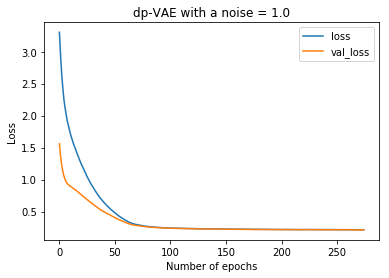

In [12]:
model.plot_loss()

```model.plot_accuracy()```

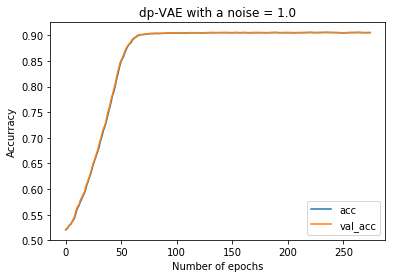

In [13]:
model.plot_accuracy()

The model class contains an instance **epsilon** that stores the privacy budget value for each trained epoch. We can have a look at the last five values:

```model.epsilon[-5:]```

In [14]:
model.epsilon[-5:]

[5.960752370796537,
 5.9728288779901195,
 5.984905385183703,
 5.996981892377286,
 6.009058399570868]

### 2. Train VAE in a public mode
For a comparison we can train VAE model in a public mode by simply setting ***the privacy parameter*** to False. As the privacy budget is not applicable in a public mode we cannot use the stop criterion and have to define the number of epochs to train our model. To avoid overfitting we set a new parameter ***decay*** that is available only in Public mode and decrease ***the learning rate***. 

```model_public = VAE_model(format_data, epsilon_std = 15.0, privacy = False, epoch = 100, batch_size = 64, 
                         decay = 1e-4, learn_rate=0.0001)```

In [15]:
model_public = VAE_model(format_data, epsilon_std = 15.0, privacy = False, epoch = 100, batch_size = 64, 
                         decay = 1e-4, learn_rate=0.0001)

W0816 14:26:11.242383 37504 nn_ops.py:4202] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.



The summary of VAE model structure

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 110)          0                                            
__________________________________________________________________________________________________
inputs (Dense)                  (None, 32)           3552        encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 32)           0           inputs[0][0]                     
__________________________________________________________________________________________________
z_mu (Dense)                    (None, 2)            66          dropout_2[0][0]                  
________________________________________________________________________

Epoch 62/100
 - 1s - loss: 0.3054 - acc: 0.8993 - val_loss: 0.2916 - val_acc: 0.8995
Epoch 63/100
 - 1s - loss: 0.3034 - acc: 0.8996 - val_loss: 0.2891 - val_acc: 0.8997
Epoch 64/100
 - 1s - loss: 0.3016 - acc: 0.8995 - val_loss: 0.2900 - val_acc: 0.9000
Epoch 65/100
 - 1s - loss: 0.2996 - acc: 0.8998 - val_loss: 0.2873 - val_acc: 0.9002
Epoch 66/100
 - 1s - loss: 0.2984 - acc: 0.9001 - val_loss: 0.2858 - val_acc: 0.9002
Epoch 67/100
 - 1s - loss: 0.2968 - acc: 0.9001 - val_loss: 0.2848 - val_acc: 0.9007
Epoch 68/100
 - 1s - loss: 0.2951 - acc: 0.9003 - val_loss: 0.2839 - val_acc: 0.9007
Epoch 69/100
 - 1s - loss: 0.2944 - acc: 0.9006 - val_loss: 0.2832 - val_acc: 0.9008
Epoch 70/100
 - 1s - loss: 0.2944 - acc: 0.9009 - val_loss: 0.2806 - val_acc: 0.9012
Epoch 71/100
 - 1s - loss: 0.2917 - acc: 0.9011 - val_loss: 0.2814 - val_acc: 0.9015
Epoch 72/100
 - 1s - loss: 0.2919 - acc: 0.9013 - val_loss: 0.2798 - val_acc: 0.9016
Epoch 73/100
 - 1s - loss: 0.2894 - acc: 0.9017 - val_loss: 0.278

```model.plot_loss()```

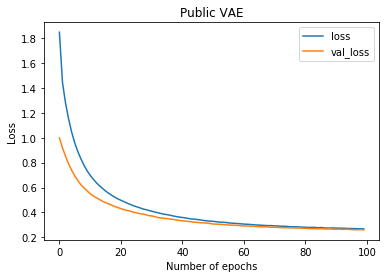

In [16]:
model_public.plot_loss()

```model.plot_accuracy()```

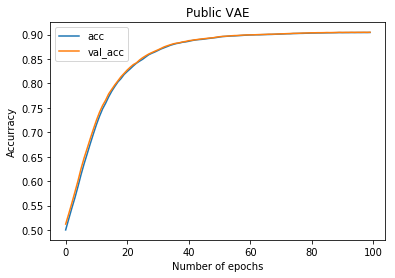

In [17]:
model_public.plot_accuracy()

## C. New Data Generation

Finally, we generate a new data using **generate_data** function and transform them back to the original format. We generated the same number of samples (n = 21815) as in the original training data for an easy comparison but the user can define the size of new dataset by setting a parameter for instance ***n_samples = 1000***. The default number is equal to the number of samples in the original training data.

In [18]:
class generate_data(object):
    def __init__(self, data, model, n_samples = None):
        self.data = data
        self.model = model
        if n_samples == None:
            self.n_samples = data.train.shape[0]
        else:
            self.n_samples = n_samples
        self.decoded_samples = self.sample_from_latent_space()
        self.decoded_numerical, self.decoded_data = self.convert_to_numeric()
        self.generated_data = self.convert_to_original()
    
    def sample_from_latent_space(self):
        z_sample = np.random.normal(size=(self.n_samples, self.data.train.shape[1]))
        decoded_samples = self.model.vae.predict(z_sample, batch_size = self.model.batch_size) 
        return decoded_samples
    
    def convert_to_numeric(self):
        decoded_data = pd.DataFrame(np.array(self.decoded_samples), columns = self.data.encoded_names)
        decoded_numerical_array = self.data.min_max_scaler.inverse_transform(decoded_data[self.data.numeric_cols])
        decoded_numerical = pd.DataFrame(decoded_numerical_array.astype(int), columns = self.data.numeric_cols)
        return decoded_numerical, decoded_data
    
    def convert_to_original(self):
        decoded_disc_array = np.array(self.decoded_data[self.data.discrete_data.columns])
        _, discreteTextDataset = self.data.discManager.convertDiscreteMatrix(decoded_disc_array)
        decoded_discrete = pd.DataFrame(np.array(discreteTextDataset).T, columns = self.data.discManager.variables)
        generated_data = pd.concat([self.decoded_numerical, decoded_discrete],axis=1)
        dic = {index:label for index, label in enumerate(self.data.original_names)}
        generated_data_reordered = generated_data.reindex(columns=dic.values())
        generated_data_reordered.replace
        return generated_data_reordered 

```new_data = generate_data(format_data, model).generated_data
new_data.head()```

In [19]:
new_data = generate_data(format_data, model).generated_data
new_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,31,Private,140984,HS-grad,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,27,0,32,United-States,<=50K
1,42,Private,221637,Masters,10,Divorced,Exec-managerial,Husband,Amer-Indian-Eskimo,Female,260,387,40,United-States,>50K
2,41,Private,83232,Some-college,8,Divorced,Craft-repair,Not-in-family,White,Male,241,5,44,United-States,<=50K
3,39,Federal-gov,48727,Some-college,9,Separated,Other-service,Own-child,White,Male,64,1,43,United-States,<=50K
4,54,Private,202697,HS-grad,10,Never-married,Craft-repair,Other-relative,White,Male,1481,157,41,Scotland,<=50K


## D. Data Quality Evaluation

After we obtained new dataset, we can explore it and check how similar this data to the original one. There are different approaches to do that.

### 1. Original vs. Generated data: a simple matching
First, we can compare by each column how many values in the generated data are the same as in the original one. From the figure below, we see that 80% of generated samples contain at least one original value. The maximum number of values that are the same in both datasets is 10 (out of 14 original columns). It means that none of the original samples is present in the generated data preserving data privacy.

In [20]:
class CompareData(object):
    def __init__(self, input_data, generated_data, hist = False):
        self.input_data = input_data
        self.generated_data = generated_data
        self.hist = hist
        self.true_number, self.true_fraction, self.compared_data = self.compare()
        self.plot()
        
    def compare(self):
        compare = self.input_data.train_original.isin(self.generated_data)
        correct_guess = compare[compare==True].sum(axis=1, skipna = True)
        true_number = []
        for i in range(1, compare.shape[1]):
            z = len(correct_guess[correct_guess>i])
            y = round(z, 2)
            true_number.append(y)  
        true_fraction = []
        for i in range(1, compare.shape[1]):
            z = len(correct_guess[correct_guess>i])/len(compare)*100
            y = round(z,2)
            true_fraction.append(y) 
        return true_number, true_fraction, compare
    
    def plot(self):
        if self.hist == True:
            plt.bar(x = range(1, self.compared_data.shape[1]), height = self.true_fraction)
            plt.xlabel('Number of correctly guessed values \nper one sample(row)')
            plt.ylabel('Fraction of samples [%]')
            plt.xticks(np.arange(0, self.compared_data.shape[1], step = 1))
            plt.show()

```res = CompareData(format_data, new_data, hist = True)
res.true_number```

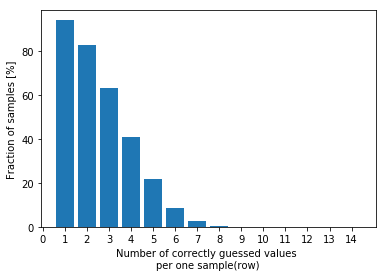

[20562, 18049, 13830, 8972, 4746, 1883, 572, 129, 18, 1, 0, 0, 0, 0]

In [21]:
res = CompareData(format_data, new_data, hist = True)
res.true_number

### 2. Original vs. Generated data: a distribution of numerical attributes
Secondly, we can compare the distribution of numerical attributes in the original and generated datasets. The figure shows us that overall generated data preserve the attributes' distributions although we can notice that the attributes' range is shrinked compared to the original one. This is due to the model was trained in the differential private mode and some outliers were removed from the model to preserve privacy. Another reason is the MinMaxScaler that is used to scale the original data for model training. Moreover, it is challenging to normalize all attributes using the same scaling method and therefore, the VAE assumption of normally distributed input data might be violated. This negative impact can be partially reduced by the parameter ***epsilon_std*** during the model training. The higher this value, the broader the attributes' range that is covered by the model. Finally, underfitted dp-VAE model can also cause the low representation of attributes' range in the generated data.

In [22]:
class CompareNumericalAttributes(object):
    def __init__(self, input_data, new_data, attribute):
        self.data = input_data.train_original
        self.new_data = new_data
        self.attribute = attribute
        self.plot_distribution()
        
    def plot_distribution(self):
        if self.data.shape[0] != self.new_data.shape[0]:
            raise ValueError('Original and generated data have different number of samples')
        else:
            self.data[self.attribute].plot('hist',label='original')
            self.new_data[self.attribute].plot('hist',label = 'generated', alpha=0.7)
            plt.legend()
            plt.show()
        return None

```hist = CompareNumericalAttributes(format_data, new_data, attribute = 'age')```

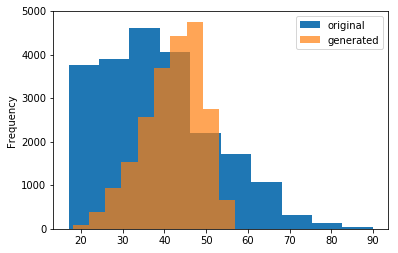

In [23]:
hist = CompareNumericalAttributes(format_data, new_data, attribute = 'age')

```hist = CompareNumericalAttributes(format_data, new_data, attribute = 'hours-per-week')```

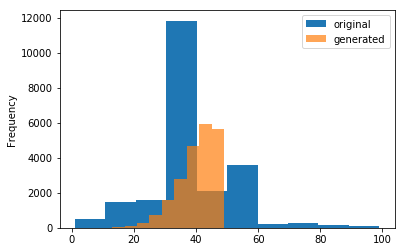

In [24]:
hist = CompareNumericalAttributes(format_data, new_data, attribute = 'hours-per-week')

```hist = CompareNumericalAttributes(format_data, new_data, attribute = 'capital-gain')```

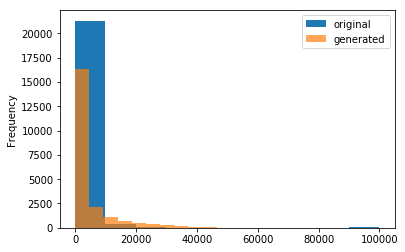

In [25]:
hist = CompareNumericalAttributes(format_data, new_data, attribute = 'capital-gain')

### 3. Original vs. Generated data: a frequency of attributes' classes
Another step is to compare the frequency of each attribute's classes in generated and original datasets to check whether the classes structure was preserved. As we can see below, the generated data (first column) preserve the class structure for all discrete attributes although the frequency of each class in generated and original datasets are clearly not the same.

In [26]:
class CompareDiscreteAttributes(object):
    def __init__(self, input_data, new_data, attribute):
        self.data = input_data.train
        self.new_data = new_data
        self.attribute = attribute
        self.freq_compare()
    
    def freq_compare(self):
        if self.data.shape[0] != self.new_data.shape[0]:
            raise ValueError('Original and generated data have different number of samples')
        else:         
            for c1, c2, c3, c4 in zip(new_data[self.attribute].value_counts().index.tolist(),
                              new_data[self.attribute].value_counts(), 
                              format_data.train_original[self.attribute].value_counts().index.tolist(),
                              format_data.train_original[self.attribute].value_counts()):
                print ("%-30s %-9s %-30s %s" % (c1, c2, c3, c4))
        return None

```comp = CompareDiscreteAttributes(input_data = format_data, new_data = new_data, attribute = 'education')```

In [27]:
comp = CompareDiscreteAttributes(input_data = format_data, new_data = new_data, attribute = 'education')

 HS-grad                       7143       HS-grad                       6983
 Some-college                  5049       Some-college                  4868
 Bachelors                     3183       Bachelors                     3603
 Masters                       1256       Masters                       1175
 Assoc-voc                     1058       Assoc-voc                     950
 10th                          642        11th                          799
 Assoc-acdm                    567        Assoc-acdm                    720
 7th-8th                       493        10th                          625
 11th                          480        7th-8th                       432
 12th                          443        Prof-school                   397
 9th                           390        9th                           354
 Doctorate                     305        Doctorate                     285
 5th-6th                       229        12th                          270
 1st-4th

```comp = CompareDiscreteAttributes(input_data = format_data, new_data = new_data, attribute = 'race')```

In [28]:
comp = CompareDiscreteAttributes(input_data = format_data, new_data = new_data, attribute = 'race')

 White                         17022      White                         18649
 Black                         2816       Black                         2059
 Asian-Pac-Islander            860        Asian-Pac-Islander            710
 Amer-Indian-Eskimo            591        Amer-Indian-Eskimo            214
 Other                         526        Other                         183


```comp = CompareDiscreteAttributes(input_data = format_data, new_data = new_data, attribute = 'sex')```

In [29]:
comp = CompareDiscreteAttributes(input_data = format_data, new_data = new_data, attribute = 'sex')

 Male                          14610      Male                          14651
 Female                        7205       Female                        7164


### 4. Original vs. Generated data: a classifier to predict a target attribute
The last step can be applied only for a labeled input data. We can build a ***train classifier*** for a target attribute based on the original train dataset and use it to predict the labels for the generated data. The accuracy of this classification is called **'similarity'** as it describes how similar the generated data to the original one that were used to train dp-VAE model. Using the same ***train classifier*** we can predict the labels for the original test data. The calculated accuracy corresponds to a common validation accuracy that is used to evaluate a classifier. Similarly, we can train another ***fake classifier*** for a target attribute based on the generated dataset and use it to predict the labels for the original test data. As far as the fake classifier is trained on the generated data that were not used to train the model, the obtained accuracy, so-called **'diversity'**, shows how diverse are new data that the model generates. The proposed evaluation scores were inspired by a paper of Shmelkov K., Schmid C. & Alahari K. (2018) How good is my GAN?

To automate the process and perform a classification for different datasets we decided to use AutoML provided by H2O.ai (http://docs.h2o.ai/). H2O.ai is an open source, in-memory, distributed, fast, and scalable machine learning and predictive analytics platform that allows to build machine learning models on big data and provides easy productionalization of those models in an enterprise environment.

In [30]:
class Classifier(object):
    def __init__(self, format_data, generated_data, target):
        self.train = format_data.train_original
        self.test = format_data.test_original
        self.generated_data = generated_data
        self.target = target
        self.h2o_fake, self.h2o_train, self.h2o_test = self.convert_to_H2O()
        self.clf_fake = self.classifier_fake()
        self.clf_train = self.classifier_train()
        self.scores = self.get_score()
        
    def convert_to_H2O(self):
        generated_data_na = self.generated_data.fillna("?")
        train_na = self.train.fillna("?")
        test_na = self.test.fillna("?")
        h2o_fake = h2o.H2OFrame(generated_data_na)
        h2o_fake[self.target] = h2o_fake[self.target].asfactor()
        h2o_train = h2o.H2OFrame(train_na)
        h2o_train[self.target] = h2o_train[self.target].asfactor()
        h2o_test = h2o.H2OFrame(test_na)
        h2o_test[self.target] = h2o_test[self.target].asfactor()
        return h2o_fake, h2o_train, h2o_test
    
    def classifier_fake(self):
        clf_fake = H2OAutoML(max_models = 5, seed = 1)
        fake = self.h2o_fake.columns
        fake.remove(self.target)
        clf_fake.train(x = fake, y = self.target, training_frame = self.h2o_fake)
        return clf_fake
    
    def classifier_train(self):
        clf_train = H2OAutoML(max_models = 5, seed = 1)
        train = self.h2o_train.columns
        train.remove(self.target)
        clf_train.train(x = train, y = self.target, training_frame = self.h2o_train)
        return clf_train
    
    def get_score(self):
        preds_valid = self.clf_train.leader.predict(self.h2o_test)                    
        acc_valid = accuracy_score(self.h2o_test[self.target].as_data_frame().values, 
                                   preds_valid['predict'].as_data_frame().values)
        preds_train = self.clf_fake.leader.predict(self.h2o_test)                    
        diversity = accuracy_score(self.h2o_test[self.target].as_data_frame().values, 
                                  preds_train['predict'].as_data_frame().values)
        preds_test = self.clf_train.leader.predict(self.h2o_fake)
        similarity = accuracy_score(self.h2o_fake[self.target].as_data_frame().values, 
                                    preds_test['predict'].as_data_frame().values)
        scores = [acc_valid, diversity, similarity]
        dic_scores = {'acc_valid': scores[0], 'diversity': scores[1], 'similarity': scores[2]}
        return dic_scores


```clf = Classifier(format_data, new_data, target= 'income')
clf.scores```

In [31]:
clf = Classifier(format_data, new_data, target= 'income')
clf.scores

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


{'acc_valid': 0.8661827656802531,
 'diversity': 0.4547738693467337,
 'similarity': 0.6409809763923906}

As we can see above, the generated data is quite similar to the original data (**'similarity'** = 0.64) and diversity of generated data is also average (**'diversity'** = 0.62). Overall, the more outliers are in the original data, the lower diversity value will be due to privacy mode. Furthermore, the validation accuracy is also average (0.87) meaning that the original data itself might not include all necessary attributes to predict the target attribute. In theory the best quality of new data generated by VAE is when the all three accuracy are roughly the same, however, it is hard to achieve for VAE trained in the private mode.

***
Now we learned how to generate new data using Variational Autoencoder in the differential private mode. We hope that this short tutorial was helpful although there are still many things that can be improved. Any feedback and suggestions will be highly appreciated:
 - anderson.santana.de.oliveira@sap.com
 - ldymytrova@gmail.com

Thank you for your interest and time!